This notebook will quickly draw our attention for getting validation scores via **KFold** Cross validation.  This is a more thorough way of generating validation scores.  

The standard way of validating model performance is by creating a training and test set, and further separating the training set into a validation set.  The test set is only used at the very end to score your final model.  Ie, your final report card for how your model performed.  The validation set is the dress rehearsal for the test set.  

Therefore, the validation set is what you use to judge whether or not your model is improving or not.  

However, using a validation set has some of its own problems:  mainly that sometimes you can overfit your validation set.  There is not a guarantee that your validation set will be perfectly representative of all out-of-sample performance.  

#### KFold Cross-Validation

KFold is a more thorough way of getting validation scores from your model.  Rather than using a single validation set, it sequentially uses different sections of your training set for validation and blends them together at the end.  

The benefits of KFold cross validation are two-fold:
 - It allows you to test your model across different sections of your dataset, doing a more thorough probe of how your model performs under different conditions
 - Your collection of scores allows you to develop best & worst case scenarios for how your model performs
 
The basic process looks like this:

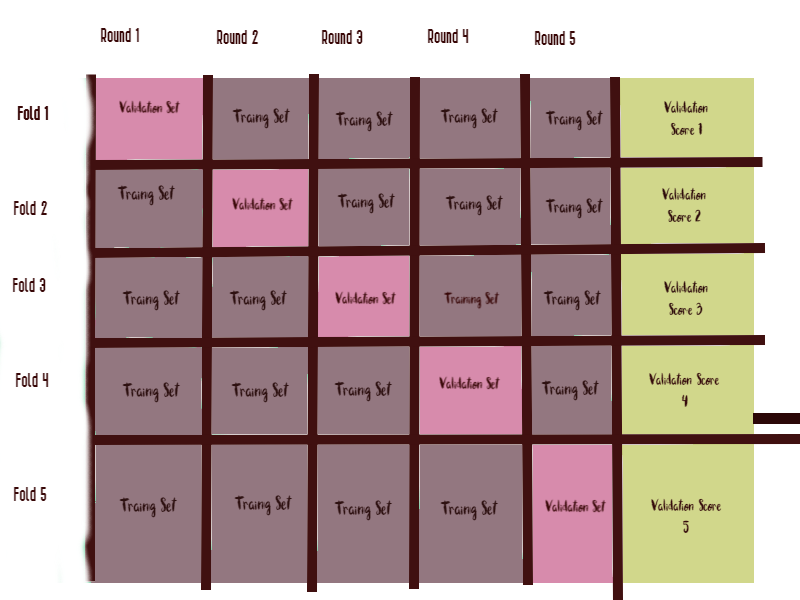

In [3]:
from IPython.display import Image, display

display(Image('./Assets/KFold.png'))

Implementing this code in Scikit Learn is very straightforward.

Using the boston data set, we can do it like so:

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv('../data/housing.csv')

In [20]:
# create training & test set
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1985)

Let's do a quick Val/Test check

In [21]:
# create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1985)

gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gbm.score(X_val, y_val)

0.8874125272430098

In [22]:
# and on the test set
gbm.score(X_test, y_test)

0.8619934521134556

This looks fine, but let's check the same results we get from KFold, using the `cross_val_score` function.

In [23]:
# cv is the number of folds to use
scores = cross_val_score(estimator=gbm, X=X_train, y=y_train, cv=10)

In [24]:
# and look at our validation scores
scores

array([0.6997805 , 0.90468165, 0.58545487, 0.78227173, 0.89465711,
       0.88107487, 0.93058938, 0.90209234, 0.84936813, 0.95703778])

In [25]:
# and the KFold validation score would be:
scores.mean()

0.8387008345485727

Here, it can easily be seen that our different folds returned very different results, which gives us a better estimate of potential high & low points of our model.

### KFold for Time Series Data

Throughout most of Unit 2 & 3 we have been working with the restaurants dataset, which requires Time Series modeling.  You can apply the same basic principle, but the key distinction is that you *always want to score data that comes after data you fit your model on*.

The KFold version for Time Series data would then be this:

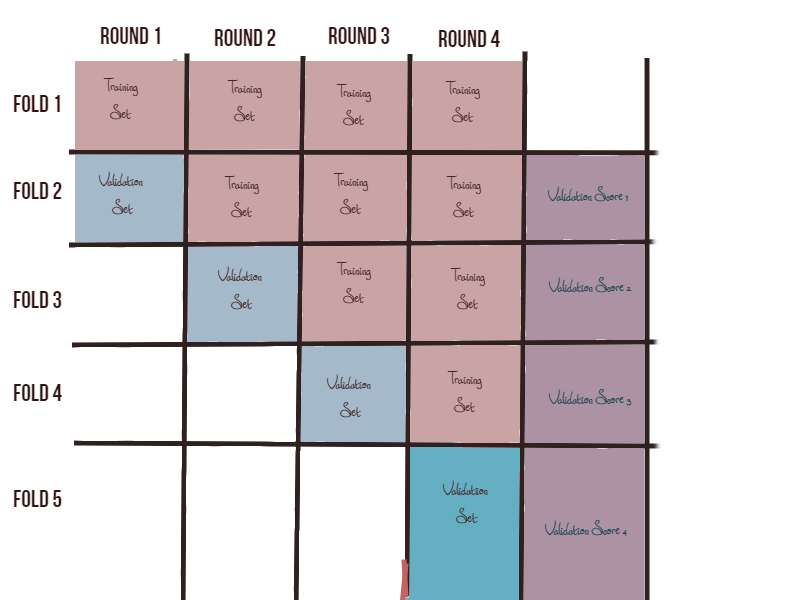

In [29]:
display(Image('./assets/TimeSeriesKFold.png'))

In order to apply this different style of KFold, we need to make use of the *splitter* class, which is a segment of the SciKit learn API that implements specialized versions of KFold when the standard will not do.  

Some examples include:

 - Time Series Splitting
 - Stratified Splitting (important for classification)
 - Using different group characteristics as the holdout set (ie, Group KFold)
 - Nested KFold (KFold when you repeatedly create different splits from the training & test set)
 
The URL for the different classes can be found here:  https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

For now we're going to use the `TimeSeriesSplit` class.  Let's give it a shot, using the `restaurants` dataset.

In [37]:
# import the restaurants dataset
import category_encoders as ce
from sklearn.pipeline import make_pipeline
df = pd.read_csv('../data/restaurant data/restaurants.csv', parse_dates=['visit_date'])
df.drop('calendar_date', axis=1, inplace=True)
df = df.fillna(0)
df.head()

,id,visit_date,visitors,day_of_week,holiday,genre,area,latitude,longitude,reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0


In [38]:
# we'll initialize our model, and fit
df.sort_values(by = ['id', 'visit_date'], ascending=True, inplace=True)
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())
from sklearn.model_selection import TimeSeriesSplit

# use the train_test_split helper function to split into training & test
train = df.groupby('id').apply(lambda x: x.iloc[:-30])
test  = df.groupby('id').apply(lambda x: x.iloc[-30:])

# sort everything by date again - necessary for TimeSeriesSplitting
train.sort_values(by='visit_date', ascending=True, inplace=True)
test.sort_values(by='visit_date', ascending=True, inplace=True)

# create our training & test sets
X_train, y_train = train.drop(['visitors', 'visit_date'], axis=1), train['visitors']
X_test, y_test   = test.drop(['visitors', 'visit_date'], axis=1), test['visitors']

# we're going to fit our model in 10 successive time series steps
TimeSplitter = TimeSeriesSplit(n_splits=20)
# and we're going to use our TimeSplitter class in the cv argument for cross_val_score
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=TimeSplitter)

In [39]:
# so let's look at our scores!
scores

array([0.47922852, 0.43576809, 0.47981852, 0.31215017, 0.41219577,
       0.45972618, 0.41848891, 0.3888768 , 0.4628804 , 0.46519971,
       0.48716563, 0.42416111, 0.40444841, 0.47597749, 0.35652846,
       0.43053213, 0.47096552, 0.45779283, 0.48770543, 0.39910102])

In [40]:
# the average
scores.mean()

0.43543555580393944

In [43]:
# and let's plot it out
import plotly.express as px

# the trendline can help get a feel for overall patterns
px.scatter(scores, trendline='ols')